# Ensemble Learning Exercise

## 1. Implementing Random Forest From Scratch (30 points)
In this exercise you will need to implement a simple version of Random Forest Regressor from scratch. Your model will handle **continuous input and output**. 

1.1. Compelete the skeleton class below (you should use scikit-learn's `DecisionTreeRegressor` model that the `TreeEnsemble` will use)
  - `X` is a matrix of data values (rows are samples, columns are attributes)
  - `y` is a vector of corresponding target values
  - `n_trees` is the number of trees to create
  - `sample_sz` is the size of the sample set to use of each of the trees in the forest (chose the samples randomly, with or without repetition)
  - `n_features` is the size of features to sample. This can be a natrual number > 0, or a ratio of the features as a number in range (0,1]
  - `min_leaf` is the minimal number of samples in each leaf node of each tree in the forest
  

1.2. The `predict` function will use mean of the target values of the trees. The result is a vector of predictions matching the number of rows in `X`.

1.3. The `oob_mse` function will compute the mean squared error over all **out of bag (oob)** samples. That is, for each sample calculate the squared error using  predictions from the trees that do not contain x in their respective bootstrap sample, then average this score for all samples. See:  [OOB Errors for Random Forests](https://scikit-learn.org/stable/auto_examples/ensemble/plot_ensemble_oob.html).

1.4. To check your random forest implementation, use the boston dataset (`from sklearn.datasets import load_boston`)

  - Use the following to estimate what are the best hyper parameters to use for your model
```
for n in [1,5,10,20,50,100]:
  for sz in [50,100,300,500]:
    for min_leaf in [1,5]:
      forest = TreeEnsemble(X, y, n, sz, min_leaf)
      mse = forest.oob_mse()
      print("n_trees:{0}, sz:{1}, min_leaf:{2} --- oob mse: {3}".format(n, sz, min_leaf, mse))
```
  
  - Using your chosen hyperparameters as a final model, plot the predictions vs. true values of all the samples in the training set . Use something like:
  ```
  y_hat = forest.predict(X)  # forest is the chosen model
  plt.scatter(y_hat, y)
  ```
 


In [138]:
import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeRegressor

import matplotlib.pyplot as plt

In [161]:
class TreeEnsemble():
    def __init__(self, X, y, n_trees, sample_sz, n_features=1, min_leaf=1):
        self.X = X
        self.y = y 
        self.n_trees = n_trees
        self.sample_sz = sample_sz
        if n_features <= 1:
            self.n_features = round(X.shape[1] * n_features)
        else:
            self.n_features = n_features
        self.min_leaf = min_leaf
        self.trees = []
        self.oob_total_idxs = np.arange(X.shape[0])

        self._fit(X, y)


    def _fit(self, X, y):

        for _ in range(self.n_trees):
            
            # randomly choose raws for tree
            selected_raws = np.random.choice(X.shape[0], size=self.sample_sz, replace=True)
            selected_features = sorted(np.random.choice(X.shape[1], size=self.n_features, replace=False))

            inbag_sample = X[selected_raws][:,selected_features]
            inbag_target = y[selected_raws]

            # calculate raws in oob
            self.oob_total_idxs = np.setdiff1d(self.oob_total_idxs, selected_raws)
            
            tree = DecisionTreeRegressor(min_samples_leaf=self.min_leaf)
            
            # fit tree and save it in self.trees
            tree.fit(inbag_sample, inbag_target)
            self.trees.append(tree)

        #print(self.oob_total_idxs)


    def predict(self, X):
        
        # predict with each tree
        predictions = np.array([tree.predict(X) for tree in self.trees])
        tree_preds = predictions.mean(axis=0)
        
        return tree_preds


    def oob_mse(self):
        
        # check if there raws in oob
        if not self.oob_total_idxs.size:
            return "Out-of-bag set is empty"
        else:
            # oob set
            y_oob = self.y[self.oob_total_idxs]
            
            y_pred_2 = self.predict(self.X[self.oob_total_idxs])
            print(y_pred_2)

            # make prediction and extract oob
            y_pred = self.predict(self.X)
            y_pred_oob = y_pred[self.oob_total_idxs]

            print(y_pred_oob)

            oob_mse = np.mean((y_oob - y_pred_oob) ** 2)
            
            return oob_mse



In [127]:
data_url = "http://lib.stat.cmu.edu/datasets/boston"
raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
X = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
y = raw_df.values[1::2, 2]


In [136]:
for n in [1,5,10,20,50,100]:
  for sz in [50,100,300,500]:
    for min_leaf in [1,5]:
      forest = TreeEnsemble(X, y, n, sz, min_leaf=min_leaf)
      mse = forest.oob_mse()
      print("n_trees:{0}, sz:{1}, min_leaf:{2} --- oob mse: {3}".format(n, sz, min_leaf, mse))

n_trees:1, sz:50, min_leaf:1 --- oob mse: 29.687717391304346
n_trees:1, sz:50, min_leaf:5 --- oob mse: 29.614013250180765
n_trees:1, sz:100, min_leaf:1 --- oob mse: 49.492749391727486
n_trees:1, sz:100, min_leaf:5 --- oob mse: 22.914970759820903
n_trees:1, sz:300, min_leaf:1 --- oob mse: 25.275745454545458
n_trees:1, sz:300, min_leaf:5 --- oob mse: 18.537672809700904
n_trees:1, sz:500, min_leaf:1 --- oob mse: 16.296649746192895
n_trees:1, sz:500, min_leaf:5 --- oob mse: 13.91841505659311
n_trees:5, sz:50, min_leaf:1 --- oob mse: 21.536624675324678
n_trees:5, sz:50, min_leaf:5 --- oob mse: 29.741138168041733
n_trees:5, sz:100, min_leaf:1 --- oob mse: 14.880008465608464
n_trees:5, sz:100, min_leaf:5 --- oob mse: 18.3429004998703
n_trees:5, sz:300, min_leaf:1 --- oob mse: 5.318276923076921
n_trees:5, sz:300, min_leaf:5 --- oob mse: 33.19474614382716
n_trees:5, sz:500, min_leaf:1 --- oob mse: 4.142799999999998
n_trees:5, sz:500, min_leaf:5 --- oob mse: 3.4663650285756282
n_trees:10, sz:50,

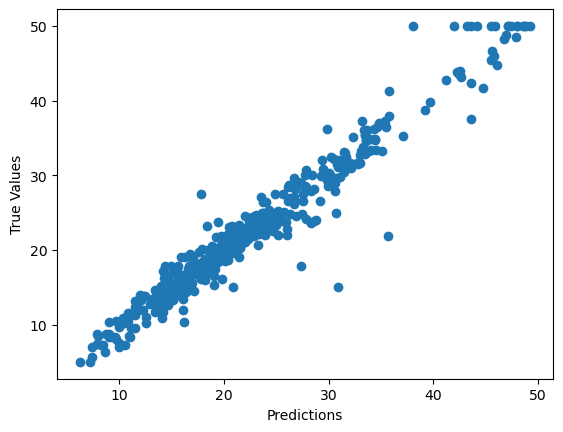

In [160]:
forest = TreeEnsemble(X, y, 20, 300, min_leaf=1)
y_hat = forest.predict(X) 
plt.scatter(y_hat, y)
plt.xlabel("Predictions")
plt.ylabel("True Values")
plt.show()

## 2. Implementing AdaBoost From Scratch (30 points)


2.1.   Implement the AdaBoost algorithm for classification task. Your `AdaBoost` class should receive a method for creating a weak learner, which has a fit and predict methods (**hint**: you can simulate re-weighting of the samples by an appropriate re-sampling of the train set).

2.2.   Use your model to find a strong classifier on the sample set given below, using $n$ weak learners:

2.2.1. For the base weak learners, use any classifier you want (check different types with different configuration, keep them simple = Weak). 

2.2.2. Split the sample set into train and test sets.

2.2.3 Plot the final decision plane of your classifier for $n\in \{1, 2, 3, 5, 10, 50\}$, and visualize the final iteration weights of the samples in those plots.
    - How does the overall train set accuracy changes with $n$?
    - Does you model starts to overfit at some point?





In [ ]:
from sklearn.datasets import make_circles
from matplotlib import pyplot
from pandas import DataFrame

# generate 2d classification dataset
X, y = make_circles(n_samples=1500, noise=0.2, random_state=101, factor=0.5)

# scatter plot, dots colored by class value
df = DataFrame(dict(x=X[:,0], y=X[:,1], label=y))
colors = {0:'red', 1:'blue'}
fig, ax = pyplot.subplots()
grouped = df.groupby('label')
for key, group in grouped:
    group.plot(ax=ax, kind='scatter', x='x', y='y', label=key, color=colors[key])
pyplot.show()

## 3. Boosting Trees from Scratch (40 points)
1. Use the scikit-learn's DecisionTreeRegressor (again :) with `max_depth = 1` (stumps)  to write a L2Boost model which minimize the L2 square loss iteration by iteration.
Reminder: in each step, build a decision tree to minimize the error between the true label and the accumulated (sum) of the previous step predictions.
![alt text](https://explained.ai/gradient-boosting/images/latex-321A7951E78381FB73D2A6874916134D.svg)
2. Use the Boston dataset to plot the MSE as a function of the number of trees for a logspace of `n_trees` up to 1,000. What is the optimal value of `n_trees`? of learning rate?
3. Compare the performance with a deep DecisionTreeRegressor (find the optimal `max_depth`).  Who wins?
4. Add an early-stopping mechanisim to the GBTL2 model to use a validation set to detect over-fit.